## Library

In [1]:
import torch
from torch import nn
from torch.nn.parameter import Parameter
from torch.optim.lr_scheduler import LambdaLR

import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import sympy

## Developed code

In [2]:
from SymbolicRNN import SymbolicRNN
from stringAgraph import stringAgraph
from evaluateAgraph import evaluateAgraph
from localOptimizer import localOptimizer
from Agraph import Agraph, binary_node
from defineAgraph import defineAgraph

In [3]:
if torch.cuda.is_available():
    print("Good to go!")
    device = "cuda"
else:
    device = 'cpu'

Good to go!


## Select operators 

In [4]:
selected_operator = ['+','-','*','/']

In [5]:
idx_to_op = ['<NULL>','c','x']
idx_to_op += selected_operator
op_to_idx = {w: i for i, w in enumerate(idx_to_op)}
D = len(idx_to_op)
print("The size of dictionary is:{}".format(D))
print("idx_to_op:",idx_to_op)
print("op_to_idx:",op_to_idx)

The size of dictionary is:7
idx_to_op: ['<NULL>', 'c', 'x', '+', '-', '*', '/']
op_to_idx: {'<NULL>': 0, 'c': 1, 'x': 2, '+': 3, '-': 4, '*': 5, '/': 6}


## Training algorithm

In [6]:
def training(X,y,lr,idx_to_op,op_to_idx,D,E,H,maxiter,threshold,epoch,method):
    
    model = SymbolicRNN(idx_to_op,op_to_idx,
                     X,y,
                     method,maxiter,threshold,
                     D,E,H)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_model = None
    best_reward = -np.inf
    reward_array = []
    loss_array = []
    cost_array = []
    s_lr = lr
    for j in range(epoch):
        
        optimizer.zero_grad()
        agraph,loss,reward,cost = model(deterministic=False)
        loss.backward()
        optimizer.step()
        
        if reward>best_reward:
            best_model = model
            best_reward = reward
            best_agraph = agraph
            
        reward_array.append(best_reward)
        loss_array.append(loss.item())
        cost_array.append(cost.item())
        if j%100==0 or j==epoch-1:
            print('epoch {}'.format(j))
            print('Reward is:',reward)
            print("Possbility:")
            print(agraph.p_tau)
            print("Selected operator:")
            print(agraph.preorder)
            exp = stringAgraph(agraph.root,idx_to_op)
            print("Obtained equation is:",sympy.expand(exp))
            print()
        
        if torch.all(agraph.p_tau>0.95).item() and reward>0.99:
            break
            
            
    print('Terminate at epoch {}'.format(j))
    print('Reward is:',reward)
    exp = stringAgraph(agraph.root,idx_to_op)
    print("Obtained equation is:",sympy.expand(exp))
    print()
    return best_agraph,best_model,model,reward_array,loss_array,cost_array

In [7]:
def sampling_equation(model,idx_to_op,n):
    for i in range(n):
        print("###### Start {}-test ######".format(i+1))
        agraph,loss,reward,cost = model(deterministic=False)
        p_tau = agraph.p_tau
        operators = agraph.preorder
        exp = stringAgraph(agraph.root,idx_to_op)
        print('Obtained equation is: ',sympy.expand(exp))
        for j in range(len(p_tau)):
            p,op = p_tau[j],operators[j]
            p*=100
            p = np.round(p.item(),2)
            print('Node {}: {} is sampled with {}%'.format(j+1,idx_to_op[int(op)],p))
        
        print("###### End {}-test ######".format(i+1))
        print()
    return agraph

## Test-0

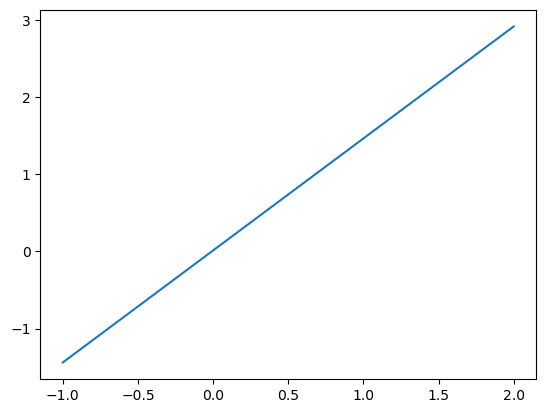

In [19]:
n = 50
X = np.linspace(-1,2,n)
y = 1.452*X + 0.012
plt.plot(X,y)

In [20]:
D,E,H = len(idx_to_op),40,40
maxiter = 11
threshold = 0.8
epoch = 5000
method = 'rmm'
lr = 1e-2
best_agraph,best_model,model,reward_array,loss_array,cost_array = training(X,y,lr,idx_to_op,op_to_idx,D,E,H,maxiter,threshold,epoch,method)

epoch 0
Reward is: 0.49999999999999933
Possbility:
tensor([0.4392, 0.2846, 0.2513, 0.2708, 0.1422, 0.2913, 0.2580, 0.6975, 0.3490,
        0.4660, 0.6682], grad_fn=<SliceBackward0>)
Selected operator:
tensor([6., 2., 6., 1., 6., 6., 5., 2., 1., 2., 2.])
Obtained equation is: 0.73799991076980907

epoch 100
Reward is: 0.9999999968050344
Possbility:
tensor([0.9697, 0.6238, 0.9869, 0.9747, 0.9844, 0.9998, 1.0000, 0.9999, 0.9930,
        0.9999, 0.9756], grad_fn=<SliceBackward0>)
Selected operator:
tensor([4., 4., 4., 6., 5., 1., 2., 1., 1., 1., 1.])
Obtained equation is: 1.451999997122507*x + 0.012000004653748168

Terminate at epoch 198
Reward is: 0.9999999968050344
Obtained equation is: 1.451999997122507*x + 0.012000004653748168



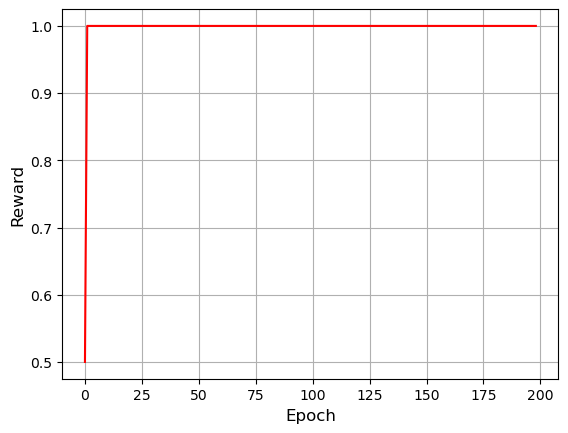

In [22]:
plt.plot(np.arange(0,len(reward_array)),reward_array,color='red')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Reward',fontsize=12)
plt.grid()

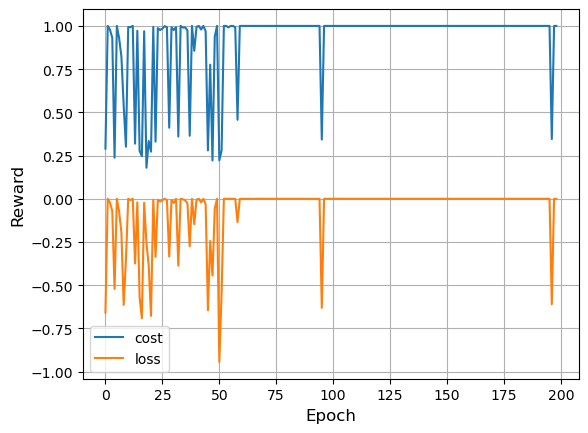

In [23]:
plt.plot(cost_array,label='cost')
plt.plot(loss_array,label='loss')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Reward',fontsize=12)
plt.grid()
plt.legend()

In [24]:
exp = stringAgraph(best_agraph.root,idx_to_op)
print('Obtained equation is: ',sympy.expand(exp))
print('Target expression is: 1.452*X + 0.012')

Obtained equation is:  1.4520000007493383*x + 0.0119999998187056
Target expression is: 1.452*X + 0.012


In [25]:
n = 3
agraph = sampling_equation(model,idx_to_op,n)

###### Start 1-test ######
Obtained equation is:  1.451999997122507*x + 0.012000004653748168
Node 1: - is sampled with 99.06%
Node 2: - is sampled with 98.71%
Node 3: - is sampled with 99.84%
Node 4: / is sampled with 96.61%
Node 5: * is sampled with 99.75%
Node 6: c is sampled with 99.97%
Node 7: x is sampled with 100.0%
Node 8: c is sampled with 99.99%
Node 9: c is sampled with 99.31%
Node 10: c is sampled with 99.99%
Node 11: c is sampled with 97.1%
###### End 1-test ######

###### Start 2-test ######
Obtained equation is:  1.451999997122507*x + 0.012000004653748168
Node 1: - is sampled with 99.06%
Node 2: - is sampled with 98.71%
Node 3: - is sampled with 99.84%
Node 4: / is sampled with 96.61%
Node 5: * is sampled with 99.75%
Node 6: c is sampled with 99.97%
Node 7: x is sampled with 100.0%
Node 8: c is sampled with 99.99%
Node 9: c is sampled with 99.31%
Node 10: c is sampled with 99.99%
Node 11: c is sampled with 97.1%
###### End 2-test ######

###### Start 3-test ######
Obtaine

In [26]:
y_hat_best = evaluateAgraph(best_agraph.root,idx_to_op,X,constants=[])
y_hat_model = evaluateAgraph(agraph.root,idx_to_op,X,constants=[])

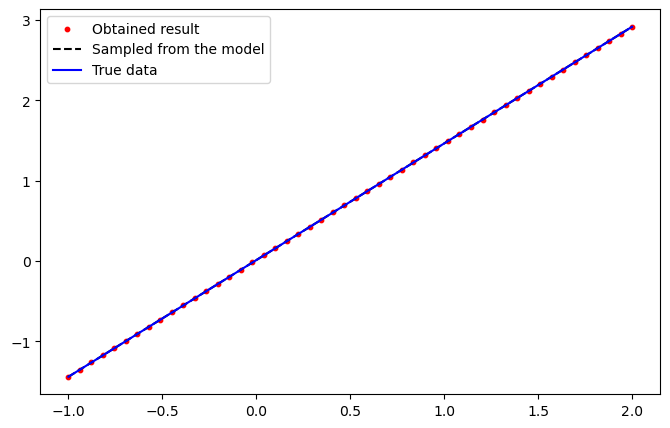

In [27]:
plt.figure(figsize = (8,5))
plt.scatter(X,y_hat_best,color='red',s=10,label='Obtained result')
plt.plot(X,y_hat_model,ls='--',color = 'black',label='Sampled from the model')
plt.plot(X,y,color='blue',label='True data')
plt.legend()

## Test-1

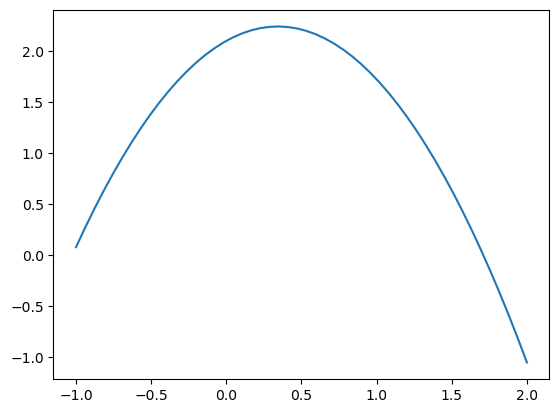

In [28]:
n = 50
X = np.linspace(-1,2,n)
y = -1.2*X**2 + 0.823*X + 2.1
plt.plot(X,y)

In [30]:
D,E,H = len(idx_to_op),40,40
maxiter = 25
threshold = 0.8
epoch = 1000
method = 'rmm'
lr = 5e-3
best_agraph,best_model,model,reward_array,loss_array,cost_array = training(X,y,lr,idx_to_op,op_to_idx,D,E,H,maxiter,threshold,epoch,method)

epoch 0
Reward is: 0.0
Possbility:
tensor([0.1845, 0.1488, 0.1849, 0.2088, 0.0942, 0.0537, 0.1659, 0.5087, 0.2466,
        0.3065, 0.1959, 0.4891, 0.2121, 0.2003, 0.3219, 0.1925, 0.3695, 1.0000,
        0.8066, 0.6224, 0.7998, 0.6235, 0.4456, 0.3880, 0.4404],
       grad_fn=<SliceBackward0>)
Selected operator:
tensor([6., 6., 2., 6., 4., 2., 2., 4., 5., 5., 1., 3., 3., 6., 5., 5., 1., 2.,
        2., 2., 2., 1., 1., 1., 2.])
Obtained equation is: zoo

epoch 100
Reward is: 0.5183544606175358
Possbility:
tensor([0.5143, 0.9532, 0.9866, 0.8415, 0.1970, 0.9465, 0.9510, 0.9870, 0.9545,
        0.9197, 0.9827, 0.3211, 0.8781, 0.9925, 0.9996, 0.9608, 0.9995, 0.9936,
        0.3439, 0.9834, 0.9997, 0.9816, 0.9768, 0.6651, 0.9337],
       grad_fn=<SliceBackward0>)
Selected operator:
tensor([4., 3., 3., 5., 6., 3., 3., 4., 4., 4., 4., 6., 2., 1., 1., 2., 2., 2.,
        2., 1., 2., 2., 2., 1., 2.])
Obtained equation is: 1.4632655726403823 - 0.3770001108979866*x

epoch 200
Reward is: 0.5183544606

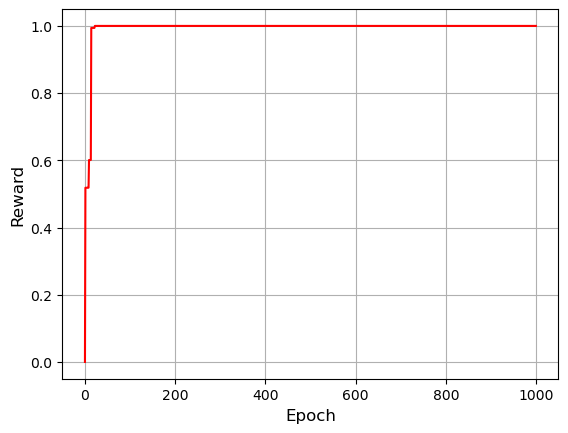

In [31]:
plt.plot(np.arange(0,len(reward_array)),reward_array,color='red')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Reward',fontsize=12)
plt.grid()

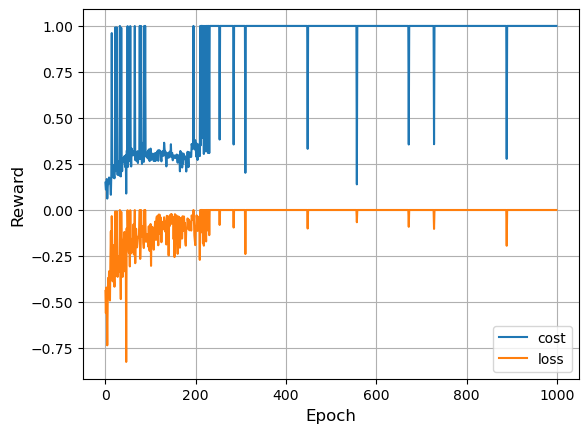

In [32]:
plt.plot(cost_array,label='cost')
plt.plot(loss_array,label='loss')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Reward',fontsize=12)
plt.grid()
plt.legend()

In [33]:
exp = stringAgraph(best_agraph.root,idx_to_op)
print('Obtained equation is: ',sympy.expand(exp))
print('Target expression is: - 1.2*X**2 + 0.823*X + 2.1')

Obtained equation is:  -1.2000000005263385*x**2 + 0.82300000059099366*x + 2.0999999979155179
Target expression is: - 1.2*X**2 + 0.823*X + 2.1


In [34]:
n = 3
agraph = sampling_equation(model,idx_to_op,n)

###### Start 1-test ######
Obtained equation is:  -1.2000000170686276*x**2 + 0.8230000132611917*x + 2.0999999867070727
Node 1: - is sampled with 98.85%
Node 2: - is sampled with 99.57%
Node 3: - is sampled with 99.6%
Node 4: - is sampled with 99.92%
Node 5: / is sampled with 99.92%
Node 6: + is sampled with 100.0%
Node 7: + is sampled with 68.92%
Node 8: - is sampled with 99.94%
Node 9: * is sampled with 99.99%
Node 10: - is sampled with 99.95%
Node 11: - is sampled with 99.96%
Node 12: * is sampled with 100.0%
Node 13: x is sampled with 99.66%
Node 14: c is sampled with 100.0%
Node 15: c is sampled with 100.0%
Node 16: x is sampled with 99.95%
Node 17: x is sampled with 99.98%
Node 18: x is sampled with 100.0%
Node 19: c is sampled with 100.0%
Node 20: x is sampled with 100.0%
Node 21: c is sampled with 99.97%
Node 22: c is sampled with 99.55%
Node 23: x is sampled with 100.0%
Node 24: c is sampled with 100.0%
Node 25: c is sampled with 99.79%
###### End 1-test ######

###### Start 2-

In [35]:
y_hat_best = evaluateAgraph(best_agraph.root,idx_to_op,X,constants=[])
y_hat_model = evaluateAgraph(agraph.root,idx_to_op,X,constants=[])

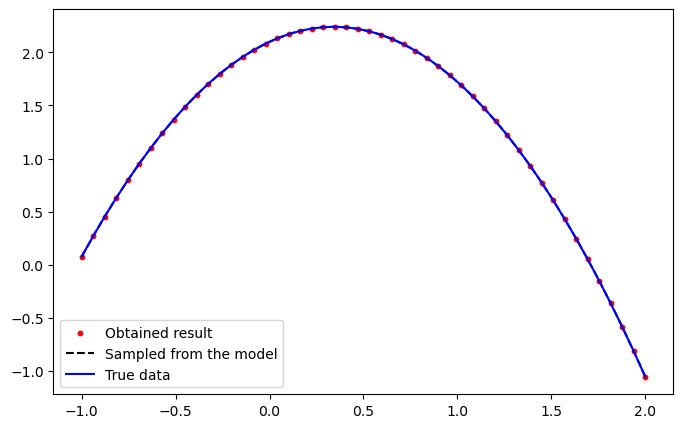

In [36]:
plt.figure(figsize = (8,5))
plt.scatter(X,y_hat_best,color='red',s=10,label='Obtained result')
plt.plot(X,y_hat_model,ls='--',color = 'black',label='Sampled from the model')
plt.plot(X,y,color='blue',label='True data')
plt.legend()

## Test - 2

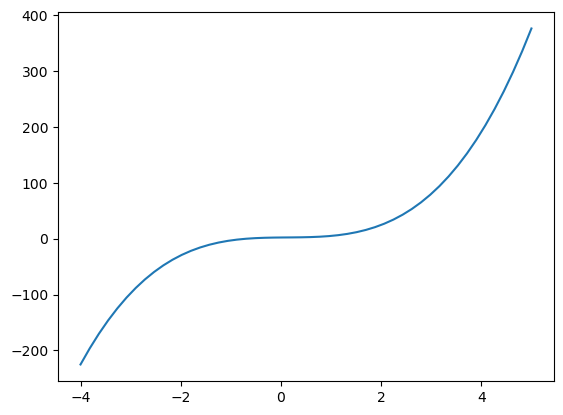

In [37]:
n = 50
X = np.linspace(-4,5,n)
y = 3.2*X**3 - 1.2*X**2 + 0.823*X + 2.1
plt.plot(X,y)

In [41]:
D,E,H = len(idx_to_op),40,40
maxiter = 31
threshold = 0.8
epoch = 1000
method = 'rmm'
lr = 1e-2
best_agraph,best_model,model,reward_array,loss_array,cost_array = training(X,y,lr,idx_to_op,op_to_idx,D,E,H,maxiter,threshold,epoch,method)

epoch 0
Reward is: 0.7078083775861859
Possbility:
tensor([0.2587, 0.2512, 0.2164, 0.1726, 0.1687, 0.2574, 0.2319, 0.2003, 0.1425,
        0.2673, 0.1954, 0.1515, 0.1439, 0.1785, 0.1903, 0.1511, 0.0857, 0.1705,
        0.4719, 0.8111, 0.4974, 0.5778, 0.6656, 0.5433, 0.7698, 0.6536, 0.4602,
        0.8134, 0.6867, 0.5861, 0.7763], grad_fn=<SliceBackward0>)
Selected operator:
tensor([3., 5., 2., 4., 6., 5., 5., 6., 1., 4., 4., 1., 6., 5., 6., 4., 3., 6.,
        2., 1., 1., 2., 2., 2., 1., 2., 2., 2., 1., 1., 1.])
Obtained equation is: -0.26377734353821877*x**3/(-1.157936993456355*x - 2.459778047549359) + 43.27436418343394*x + 3.183113858053979

epoch 100
Reward is: 0.7263026069354693
Possbility:
tensor([0.9582, 0.9875, 0.9992, 0.9996, 0.9999, 0.9967, 0.9983, 0.9892, 0.9991,
        0.9992, 0.9992, 0.9995, 0.9448, 0.9977, 0.9957, 0.9595, 1.0000, 1.0000,
        0.7571, 0.9997, 0.6808, 0.9813, 0.9920, 0.9566, 1.0000, 0.9983, 0.9951,
        1.0000, 1.0000, 0.5795, 0.9944], grad_fn=<SliceBa

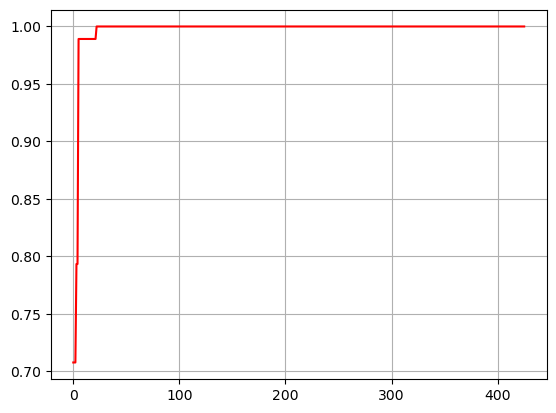

In [42]:
plt.plot(np.arange(0,len(reward_array)),reward_array,color='red')
plt.grid()

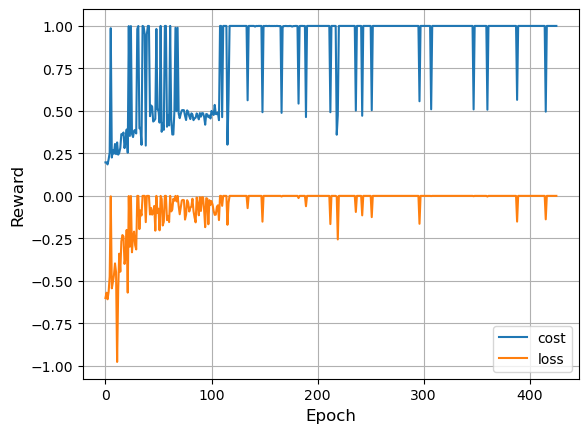

In [43]:
plt.plot(cost_array,label='cost')
plt.plot(loss_array,label='loss')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Reward',fontsize=12)
plt.grid()
plt.legend()

In [44]:
exp = stringAgraph(best_agraph.root,idx_to_op)
print('Obtained equation is: ',sympy.expand(exp))
print('Target expression is: 3.2*X**3 - 1.2*X**2 + 0.823*X + 2.1')

Obtained equation is:  3.2000000212866772*x**3 - 1.2000000183577898*x**2 + 0.82299967734575458*x + 2.100000573755609
Target expression is: 3.2*X**3 - 1.2*X**2 + 0.823*X + 2.1


In [45]:
n = 3
agraph = sampling_equation(model,idx_to_op,n)

###### Start 1-test ######
Obtained equation is:  3.2000000632897222*x**3 - 1.2000001005472273*x**2 + 0.8229992444086212*x + 2.1000000355744587
Node 1: - is sampled with 99.88%
Node 2: - is sampled with 99.84%
Node 3: * is sampled with 99.9%
Node 4: * is sampled with 99.96%
Node 5: * is sampled with 99.84%
Node 6: - is sampled with 100.0%
Node 7: - is sampled with 99.99%
Node 8: - is sampled with 100.0%
Node 9: - is sampled with 100.0%
Node 10: - is sampled with 100.0%
Node 11: * is sampled with 99.99%
Node 12: - is sampled with 99.05%
Node 13: * is sampled with 100.0%
Node 14: + is sampled with 100.0%
Node 15: - is sampled with 99.92%
Node 16: c is sampled with 99.6%
Node 17: x is sampled with 100.0%
Node 18: c is sampled with 99.99%
Node 19: x is sampled with 100.0%
Node 20: c is sampled with 100.0%
Node 21: x is sampled with 100.0%
Node 22: c is sampled with 96.81%
Node 23: c is sampled with 100.0%
Node 24: c is sampled with 100.0%
Node 25: x is sampled with 100.0%
Node 26: x is sam

In [46]:
y_hat_best = evaluateAgraph(best_agraph.root,idx_to_op,X,constants=[])
y_hat_model = evaluateAgraph(agraph.root,idx_to_op,X,constants=[])

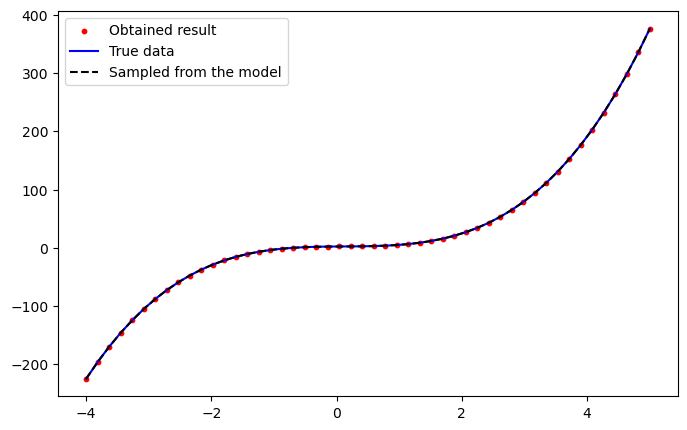

In [47]:
plt.figure(figsize = (8,5))
plt.scatter(X,y_hat_best,color='red',s=10,label='Obtained result')
plt.plot(X,y,color='blue',label='True data')
plt.plot(X,y_hat_model,ls='--',color = 'black',label='Sampled from the model')
plt.legend()

## Test - 3

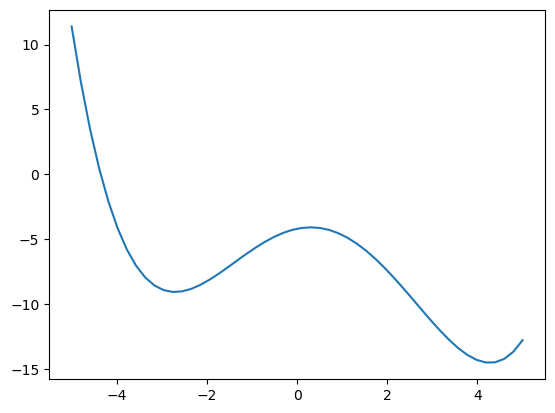

In [48]:
n = 50
X = np.linspace(-5,5,n)
y = 0.05*X**4 - 0.125*X**3 - 1.11*X**2 + 0.7053*X - 4.2
plt.plot(X,y)

In [49]:
D,E,H = len(idx_to_op),50,50
maxiter = 41
threshold = 0.8
epoch = 5000
method = 'rmm'
lr = 1e-2
best_agraph,best_model,model,reward_array,loss_array,cost_array = training(X,y,lr,idx_to_op,op_to_idx,D,E,H,maxiter,threshold,epoch,method)

epoch 0
Reward is: 0.4851514613105409
Possbility:
tensor([0.3275, 0.1752, 0.1852, 0.2616, 0.1890, 0.1716, 0.2961, 0.2194, 0.1548,
        0.1167, 0.1892, 0.3688, 0.1431, 0.1751, 0.2414, 0.1160, 0.3025, 0.3028,
        0.1010, 0.1068, 0.1700, 0.2537, 0.2054, 0.2895, 0.1691, 0.2603, 0.2305,
        0.2112, 0.4342, 1.0000, 0.7850, 0.8888, 0.8823, 0.4093, 0.5757, 0.5971,
        0.7471, 0.3994, 0.4429, 0.3732, 0.4013], grad_fn=<SliceBackward0>)
Selected operator:
tensor([6., 5., 5., 2., 5., 5., 4., 4., 5., 5., 2., 5., 2., 1., 3., 6., 2., 1.,
        5., 3., 2., 3., 3., 5., 1., 3., 3., 3., 1., 2., 2., 2., 2., 2., 1., 2.,
        2., 1., 1., 1., 2.])
Obtained equation is: -0.086940942806155656*x**3 - 0.4506901596389975*x**2 - 0.0005881683795563594*x

epoch 100
Reward is: 0.6899129432397049
Possbility:
tensor([0.8896, 0.9887, 0.9922, 0.9987, 0.9994, 0.9999, 1.0000, 0.9895, 0.9996,
        0.9909, 0.9995, 0.9995, 0.8795, 0.9992, 1.0000, 0.9983, 1.0000, 1.0000,
        0.9998, 0.9998, 1.0000, 0

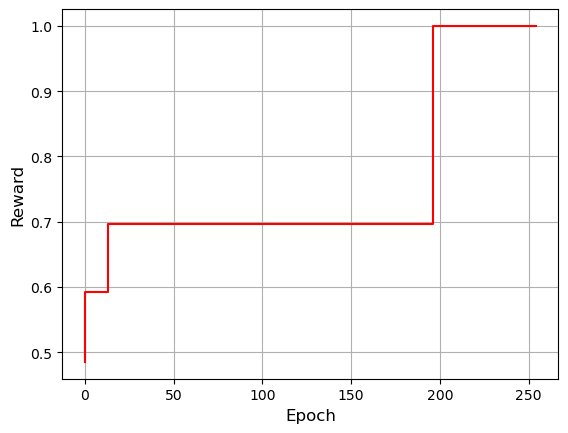

In [50]:
plt.step(np.arange(0,len(reward_array)),reward_array,color='red')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Reward',fontsize=12)
plt.grid()

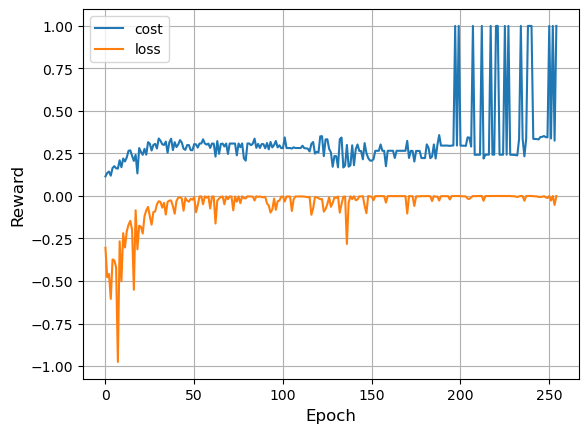

In [51]:
plt.plot(cost_array,label='cost')
plt.plot(loss_array,label='loss')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Reward',fontsize=12)
plt.grid()
plt.legend()

In [52]:
exp = stringAgraph(best_agraph.root,idx_to_op)
print('Obtained equation is: ',sympy.expand(exp))
print('Target expression is: 0.05*X**4 - 0.125*X**3 - 1.11*X**2 + 0.7053*X - 4.2')

Obtained equation is:  0.05000000304488839*x**4 - 0.12499999674766526*x**3 - 1.1100000679477431*x**2 + 0.70529994330765418*x - 4.1999997265181702
Target expression is: 0.05*X**4 - 0.125*X**3 - 1.11*X**2 + 0.7053*X - 4.2


In [53]:
n = 3
agraph = sampling_equation(model,idx_to_op,n)

###### Start 1-test ######
Obtained equation is:  -2.745385691039789e-5*x**4 - 0.056588738996453288*x**3 - 0.4503234353886213*x**2 - 0.36220705258364756*x - 0.00030072515730697804
Node 1: * is sampled with 99.98%
Node 2: * is sampled with 99.55%
Node 3: + is sampled with 99.48%
Node 4: / is sampled with 100.0%
Node 5: - is sampled with 100.0%
Node 6: - is sampled with 100.0%
Node 7: / is sampled with 100.0%
Node 8: / is sampled with 100.0%
Node 9: + is sampled with 99.99%
Node 10: - is sampled with 100.0%
Node 11: - is sampled with 98.09%
Node 12: c is sampled with 99.71%
Node 13: + is sampled with 0.63%
Node 14: + is sampled with 100.0%
Node 15: + is sampled with 100.0%
Node 16: * is sampled with 99.78%
Node 17: + is sampled with 100.0%
Node 18: + is sampled with 100.0%
Node 19: * is sampled with 99.98%
Node 20: * is sampled with 99.97%
Node 21: - is sampled with 99.97%
Node 22: x is sampled with 99.86%
Node 23: c is sampled with 98.47%
Node 24: x is sampled with 99.07%
Node 25: x is 

In [54]:
y_hat_best = evaluateAgraph(best_agraph.root,idx_to_op,X,constants=[])
y_hat_model = evaluateAgraph(agraph.root,idx_to_op,X,constants=[])

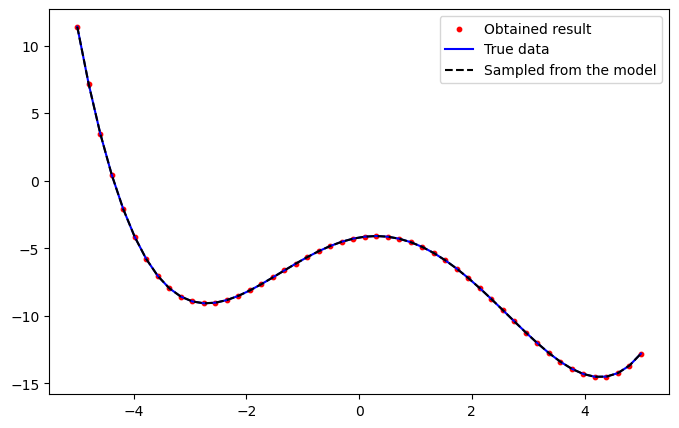

In [55]:
plt.figure(figsize = (8,5))
plt.scatter(X,y_hat_best,color='red',s=10,label='Obtained result')
plt.plot(X,y,color='blue',label='True data')
plt.plot(X,y_hat_model,ls='--',color = 'black',label='Sampled from the model')
plt.legend()

## Test - 4

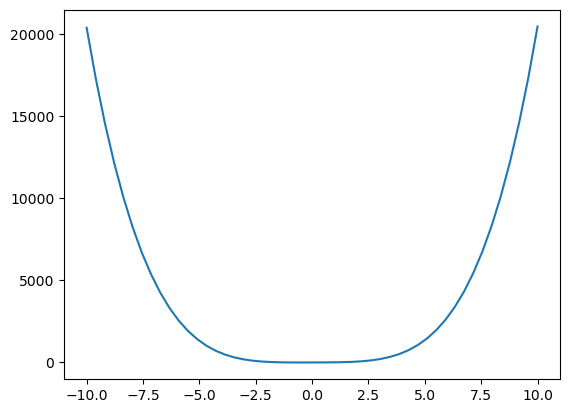

In [8]:
n = 50
X = np.linspace(-10,10,n)
y =  2.01*X**4 + 3.2*X**2 + 4*X 
plt.plot(X,y)

In [9]:
D,E,H = len(idx_to_op),50,50
maxiter = 43
threshold = 0.8
epoch = 1000
method = 'rmm'
lr = 1e-2
best_agraph,best_model,model,reward_array,loss_array,cost_array = training(X,y,lr,idx_to_op,op_to_idx,D,E,H,maxiter,threshold,epoch,method)

C:\Users\hongs\Downloads\DSA\evaluateAgraph.py:38: RuntimeWarning: divide by zero encountered in true_divide
  return left_sum / right_sum


epoch 0
Reward is: 0.4942464969865886
Possbility:
tensor([0.2565, 0.0785, 0.1188, 0.1474, 0.1029, 0.1708, 0.4066, 0.3654, 0.1538,
        0.4677, 0.2232, 0.2774, 0.1941, 0.2347, 0.1043, 0.2022, 0.1781, 0.0753,
        0.1322, 0.1539, 0.2910, 0.2260, 0.2012, 0.2846, 0.1302, 0.1467, 0.3663,
        0.2921, 0.2231, 0.3612, 0.6261, 0.3481, 0.5426, 0.5549, 0.8626, 0.6950,
        0.6330, 0.8127, 0.3828, 0.8121, 0.4368, 0.8376, 0.6754],
       grad_fn=<SliceBackward0>)
Selected operator:
tensor([3., 5., 2., 2., 5., 3., 6., 6., 2., 4., 1., 4., 6., 4., 5., 6., 6., 1.,
        6., 2., 5., 5., 6., 3., 3., 1., 2., 6., 6., 2., 1., 1., 1., 2., 2., 2.,
        1., 2., 1., 2., 2., 1., 2.])
Obtained equation is: x**2 + 0.9999999966997759*x + x/(0.0002516833009398433*x - 8.2713802144467052e-5)

epoch 100
Reward is: 0.4435003378282912
Possbility:
tensor([0.9946, 0.9998, 0.9838, 0.9922, 0.9904, 0.7028, 0.9965, 0.9990, 0.9964,
        0.9577, 0.0852, 0.0489, 0.6543, 0.3130, 0.6406, 0.9975, 0.9970, 0.0041,

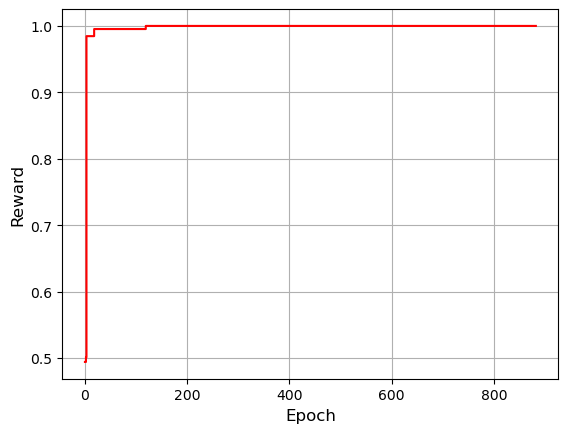

In [10]:
plt.step(np.arange(0,len(reward_array)),reward_array,color='red')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Reward',fontsize=12)
plt.grid()

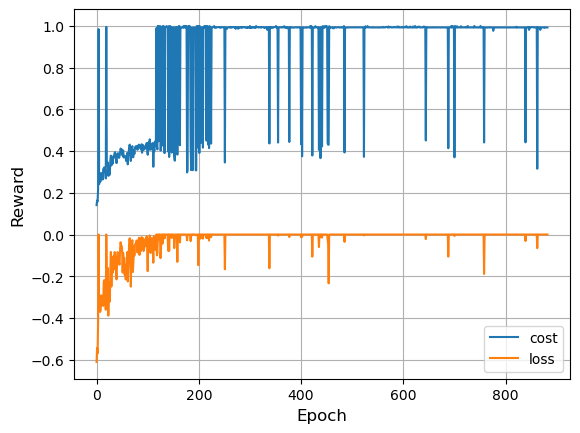

In [11]:
plt.plot(cost_array,label='cost')
plt.plot(loss_array,label='loss')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Reward',fontsize=12)
plt.grid()
plt.legend()

In [12]:
exp = stringAgraph(best_agraph.root,idx_to_op)
print('Obtained equation is: ',sympy.expand(exp))
print('Target expression is: 2.01*X**4 + 3.2*X**2 + 4*X')

Obtained equation is:  2.0095363545911925*x**4 - 0.0004970155686856792*x**3 + 1.2731173972967398*x**3/(-x - 0.71115767312577759) + 4.5192508194881796*x**2 + 3.1149725403890887*x
Target expression is: 2.01*X**4 + 3.2*X**2 + 4*X


In [16]:
n = 3
agraph = sampling_equation(model,idx_to_op,n)

###### Start 1-test ######
Obtained equation is:  2.0496155869508365*x**4 + 0.053998735786057415*x**3 - 6.5787642172238443e-5*x**2 - 0.00013157528434447689*x - 0.0095125962640093738
Node 1: / is sampled with 99.84%
Node 2: - is sampled with 99.84%
Node 3: * is sampled with 100.0%
Node 4: / is sampled with 99.96%
Node 5: / is sampled with 99.03%
Node 6: - is sampled with 3.5%
Node 7: - is sampled with 99.99%
Node 8: * is sampled with 100.0%
Node 9: - is sampled with 100.0%
Node 10: * is sampled with 99.77%
Node 11: * is sampled with 100.0%
Node 12: * is sampled with 99.95%
Node 13: - is sampled with 99.23%
Node 14: * is sampled with 99.95%
Node 15: + is sampled with 99.98%
Node 16: * is sampled with 100.0%
Node 17: - is sampled with 100.0%
Node 18: c is sampled with 100.0%
Node 19: + is sampled with 100.0%
Node 20: / is sampled with 99.99%
Node 21: c is sampled with 100.0%
Node 22: - is sampled with 99.76%
Node 23: * is sampled with 95.22%
Node 24: c is sampled with 100.0%
Node 25: x is

In [17]:
y_hat_best = evaluateAgraph(best_agraph.root,idx_to_op,X,constants=[])
y_hat_model = evaluateAgraph(agraph.root,idx_to_op,X,constants=[])

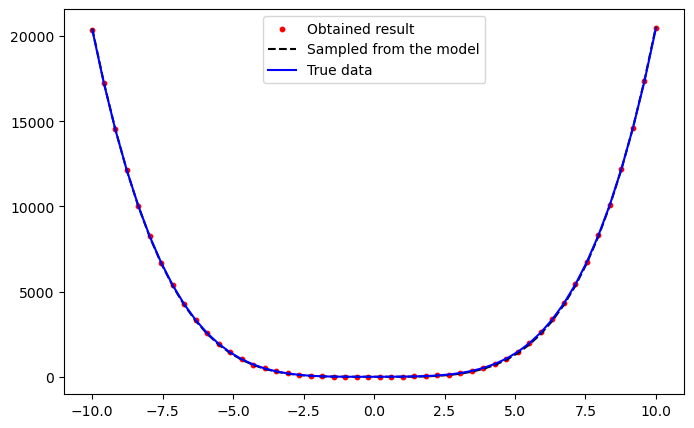

In [18]:
plt.figure(figsize = (8,5))
plt.scatter(X,y_hat_best,color='red',s=10,label='Obtained result')
plt.plot(X,y_hat_model,ls='--',color = 'black',label='Sampled from the model')
plt.plot(X,y,color='blue',label='True data')
plt.legend()